In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pynbody as pb
import glob as gl
import natsort as ns

from astropy import units as u
from astropy.constants import G
simT = u.year/(2*np.pi)
simV = u.AU / simT
from poliastro.bodies import Sun
from poliastro.twobody import Orbit, angles

In [2]:
files = ns.natsorted(gl.glob('*.[0-9]*[0-9]'))
print(str(len(files)) + ' total snapshots')

files_sub = files[::10]
print(str(len(files_sub)) + ' snapshots being measured')

3140 total snapshots
314 snapshots being measured


In [3]:
time_vals = np.empty((len(files_sub)))
a_vals = np.empty((len(files_sub), 2))
ecc_vals = np.empty((len(files_sub), 2))
inc_vals = np.empty((len(files_sub), 2))
omega_vals = np.empty((len(files_sub), 2))
Omega_vals = np.empty((len(files_sub), 2))
M_vals = np.empty((len(files_sub), 2))

for idx, val in enumerate(files_sub):
    snap = pb.load(val)
    time_vals[idx] = snap.properties['time'].in_units('yr')
    m = snap['mass'] * u.M_sun
    r = snap['pos'] * u.AU
    v = snap['vel'] * simV

    a = np.empty(len(snap)-1)
    ecc = np.empty(len(snap)-1)
    inc = np.empty(len(snap)-1)
    omega = np.empty(len(snap)-1)
    Omega = np.empty(len(snap)-1)
    M = np.empty(len(snap)-1)
    for idx1 in range(len(snap)-1):
        r_n = r[idx1+1] - r[0]
        v_n = v[idx1+1] - v[0]
        o = Orbit.from_vectors(Sun, r_n, v_n)
        a[idx1] = o.p.to(u.AU).value
        ecc[idx1] = o.ecc.value
        inc[idx1] = o.inc.value
        omega[idx1] = o.argp.value
        Omega[idx1] = o.raan.value
        M[idx1] = angles.nu_to_M(o.nu, o.ecc).value
        
    a_vals[idx] = a
    ecc_vals[idx] = ecc
    inc_vals[idx] = inc
    omega_vals[idx] = omega
    Omega_vals[idx] = Omega
    M_vals[idx] = M

In [4]:
# 1 = inner (test particle), 2 = outer (jupiter)
lam1 = (Omega_vals[:,1] + omega_vals[:,1] + M_vals[:,1])%(2*np.pi)
lam2 = (Omega_vals[:,0] + omega_vals[:,0] + M_vals[:,0])%(2*np.pi)
omegabar1 = (omega_vals[:,1] + Omega_vals[:,1])%(2*np.pi)
phi_res = (2*lam2-lam1-omegabar1 - np.pi)%(2*np.pi)

Text(0,0.5,'$\\phi$')

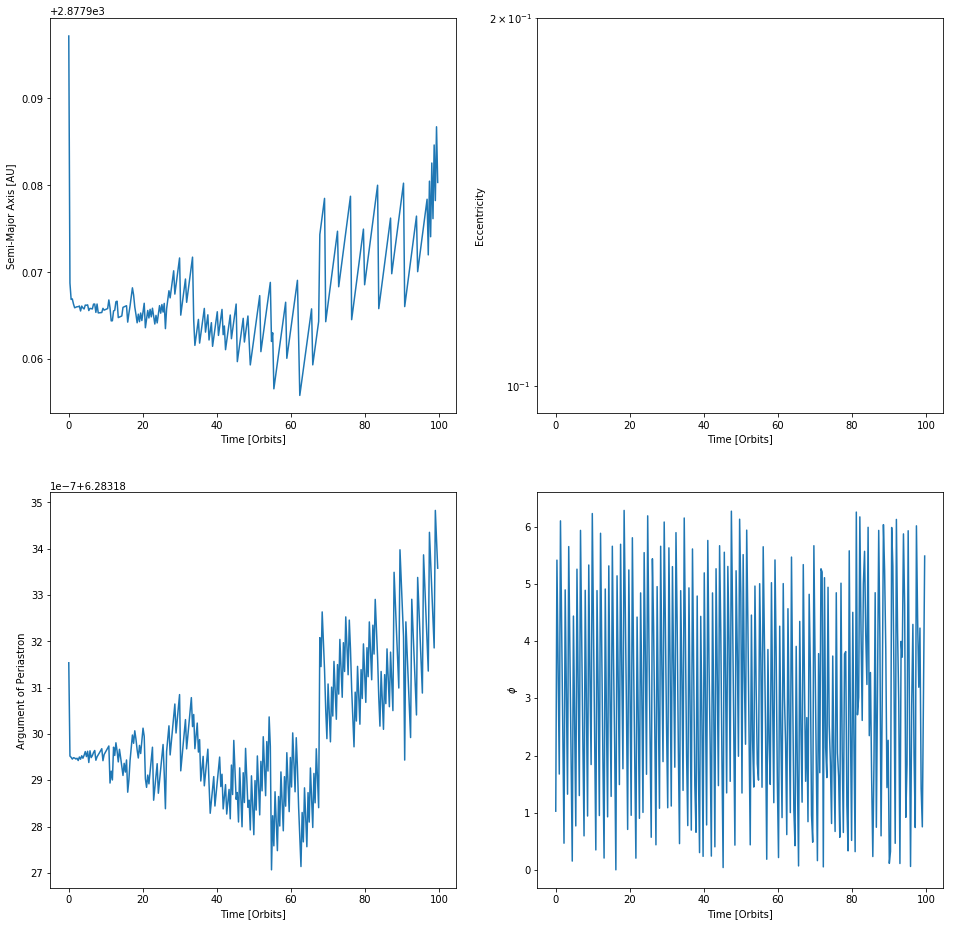

In [5]:
T_orbit = 2*np.pi*np.sqrt(((3.275*u.AU).to(u.cm)**3/(G.cgs*1*u.M_sun))).to(u.year)

fig, axes = plt.subplots(figsize=(16,16), nrows=2, ncols=2)
axes[0][0].plot(time_vals/T_orbit, a_vals[:,1])
axes[0][0].set_xlabel('Time [Orbits]')
axes[0][0].set_ylabel('Semi-Major Axis [AU]')
axes[0][1].plot(time_vals/T_orbit, ecc_vals[:,1])
axes[0][1].set_xlabel('Time [Orbits]')
axes[0][1].set_ylabel('Eccentricity')
axes[0][1].set_yscale('log')
axes[0][1].set_ylim(0.95e-1, 0.2)
axes[1][0].plot(time_vals/T_orbit, omegabar1%(2*np.pi))
axes[1][0].set_xlabel('Time [Orbits]')
axes[1][0].set_ylabel('Argument of Periastron')
axes[1][1].plot(time_vals/T_orbit, phi_res)
axes[1][1].set_xlabel('Time [Orbits]')
axes[1][1].set_ylabel(r'$\phi$')